# Spam Detection

### Libraries:

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(500)

from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
import re

from sklearn.pipeline import  Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

[nltk_data] Downloading package wordnet to /home/vlado/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Abstract

Spam Detection is a must have trait for every good email provider. It helps you filter the junk, spam messages from the real ones. There are two main camps in terms of dealing with spams assuming we are not going to achieve 100% accuracy ever - some people prefer to never let spam messages in their main sections at expense on some messages being sent wrongly in the spam section and the other prefer to be 100% sure the real messages are not sent to 'Spam'.

We are not going in any of these direction. We will pick the best model in terms of how accurate it is. We are not going to make the final call based on the recall or precision for the ham or spam target.

Credit to the Authors of the original dataset - [click](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). 

## Data processing and EDA

In [3]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data = data[['v1','v2']]

In [4]:
data.columns = ['target', 'text']

This is a NLP task so we only need the target and the text. Now let's clean the data. 

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\d', '', text)
    text = text.strip(' ')
    return text


cleaned_data = [clean_text(x) for x in data['text']]
data['text'] = cleaned_data

We perform stemming which is as essential part of every text classification problem. It reduces the words to their basic component and this is a form of normalization and even dimensionality reduction. The words 'player', 'playful' and 'playing' will all become 'play' which makes reduction of two dimensions only by performing stemming. Imagine for the effect on the entire corpus.

In [6]:
def stem_series(series):
    stemmer = SnowballStemmer(language='english', ignore_stopwords=True)
    brand_new_list = []
    for row in series:
        new_row = ''
        tokenized_row = word_tokenize(row)
        for word in tokenized_row:
            new_row += stemmer.stem(word) + ' '
        brand_new_list.append(new_row)
    return brand_new_list

In [7]:
stemmed_data = stem_series(data['text'])
data['target'] = data['target'].replace({'ham': 0, 'spam': 1})

In [8]:
data['text'] = stemmed_data
data['text']

0       go until jurong point crazi avail only in bugi...
1                                  ok lar joke wif u oni 
2       free entri in a wkli comp to win fa cup final ...
3            u dun say so earli hor u c alreadi then say 
4       nah i do not think he goe to usf he live aroun...
                              ...                        
5567    this is the nd time we have tri contact u u ha...
5568                    will ì_ b go to esplanad fr home 
5569      piti was in mood for that so any other suggest 
5570    the guy did some bitch but i act like i would ...
5571                           rofl its true to its name 
Name: text, Length: 5572, dtype: object

Lets observe our data a bit.

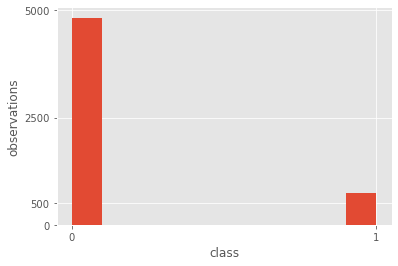

In [9]:
plt.style.use('ggplot')
plt.hist(data['target'])
plt.xlabel('class')
plt.ylabel('observations')
plt.xticks([0, 1])
plt.yticks([0,500, 2500, 5000])
plt.show()

So as expected in NLP the distribution is often really bad. This is not an exception. We should stratify our splits and we should be careful if our models do not predict only the more populated class.

Now we will use TF-IDF to turn our raw text into numbers with weights. Learn more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). 

We are gonna make the tuning of the TF-IDF with NB since it's the fastest model.

In [10]:
# params = {'tfidf__max_df': [0 , 0.25, 0.5,  0.75, 1],
#          'tfidf__min_df': [0, 0.25, 0.5, 0.75, 1],
#          'tfidf__ngram_range': [(1, 1), (1, 2), (1,3), (1, 4), (1, 5)],
#          'clf__alpha': [0.01, 0.1, 0.001, 0.0001, 2, 5, 1, 10, 20, 50, 100]
#          }

# pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords.words('english'))), ('clf', MultinomialNB())])
# grid = GridSearchCV(pipeline, param_grid=params, n_jobs=-1, verbose=0)
# grid.fit(data['text'], data['target'])

In [11]:
# grid.best_params_

In [12]:
# tf_idf = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1,2))
# processed_data = tf_idf.fit_transform(data['text'])


Due to the change in ngram range hyperparameter now we have 35656 dimensions, approximately 30k more than the original. It is a good idea to perform some form of Dimensionality reduction.

Now we need to find a good projection of the data in lower dimensions. We assume that most of the data as being turn into a sparse matrix is doesn't give us any information because it's full of zeroes. Here we perform TruncatedSVD which is the best model for big sparse matrices.

In [13]:
# svd = TruncatedSVD(n_components=4250)
# svd.fit_transform(processed_data)
# cumulative_sum = np.sum(svd.explained_variance_ratio_)
cumulative_sum = 0.9483756374157434


With 4250 singular values we were able to retrieve more than 96% of the information which should be enough for the purposes of the research. Now we can set hyperparameter max_features of the TF-idf Vectorizer to that number and proceed with the modelling with less but more important features.

In [14]:
tf_idf = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1,2), max_features=4250)
processed_data = tf_idf.fit_transform(data['text'])

Now that we are ready with all the preprocessing we can spare a minute for some EDA to double check if we've missed something. Let's find the most popular words for start.

In [15]:
sorted_voc = sorted(tf_idf.vocabulary_.items(), key=lambda x: -x[1])
x = [x[0] for x in sorted_voc[:15]]
y = [y[1] for y in sorted_voc[:15]]

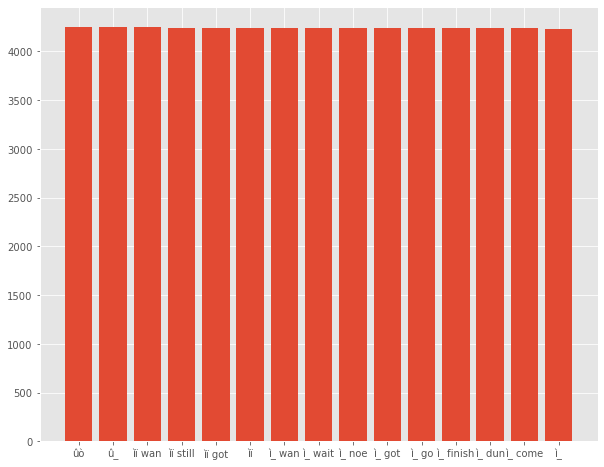

In [16]:
plt.figure(figsize=[10,8])
plt.bar(x, y)
plt.show()

Wow, this is a lot of garbage. Apparently most of the spam messages includes this sort of words not even in English. But apparently this garbage brings some information otherwise it would have been wiped by the SVD. Let's check some of the weights now.

In [17]:
weights = []
index_value={i[1]:i[0] for i in tf_idf.vocabulary_.items()}
for row in processed_data:
    weights.append({index_value[column]:value for (column,value) in zip(row.indices,row.data)})

In [18]:
most_important = [ max(weights[x].values()) for x in range(len(weights)) if len(weights[x])>0]
words = [max(weights[x], key=lambda k: weights[x][k]) for x in range(len(weights)) if len(weights[x])>0]

One quick check because those were confusing comprehensions.

In [19]:
most_important[1], words[1], weights[1]

(0.4917512924245525,
 'ok lar',
 {'ok lar': 0.4917512924245525,
  'oni': 0.4917512924245525,
  'wif': 0.3883003303876936,
  'joke': 0.41317330330870167,
  'lar': 0.3673359594503681,
  'ok': 0.24481891378328105})

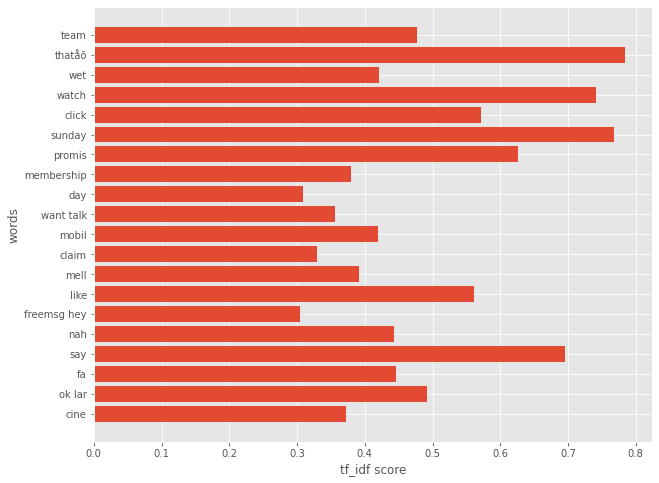

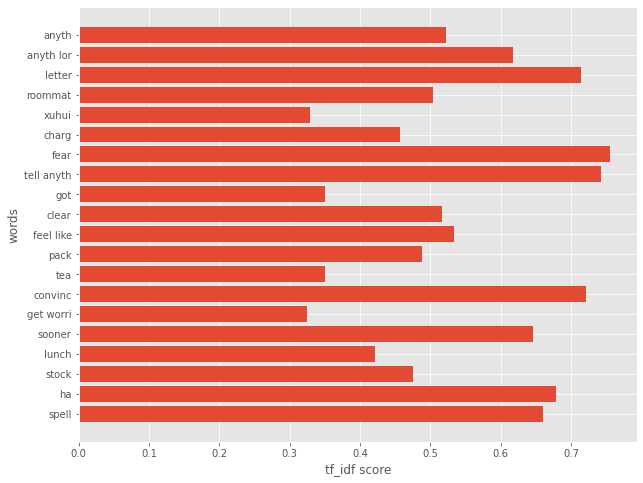

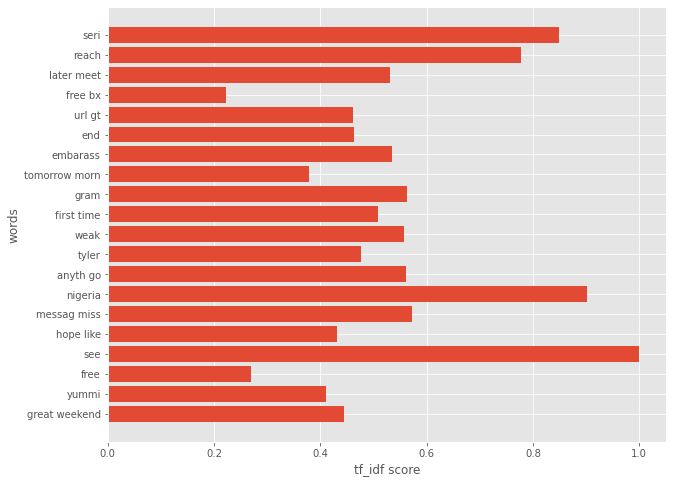

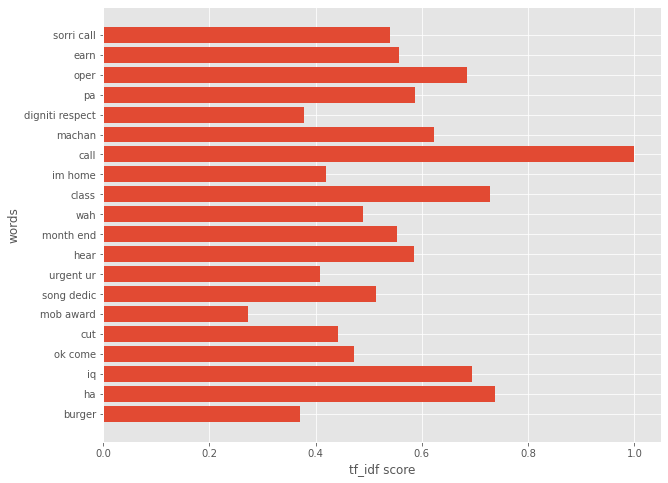

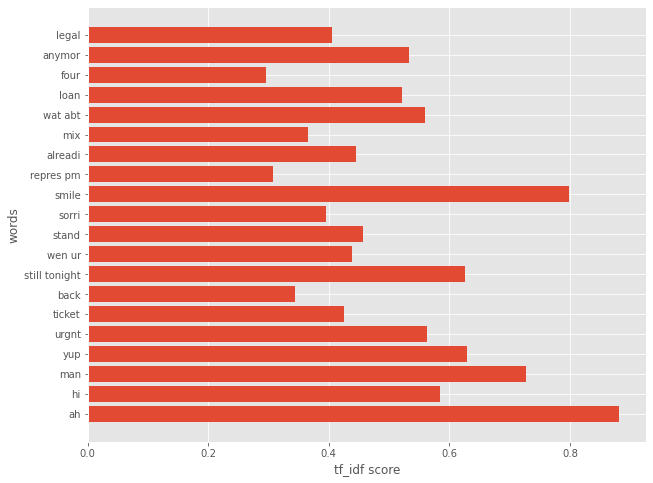

In [20]:
plt.figure(figsize=[10,8])
plt.barh(words[:20],most_important[:20])
plt.xlabel('tf_idf score')
plt.ylabel('words')
plt.show()

plt.figure(figsize=[10,8])
plt.barh(words[20:40],most_important[20:40])
plt.xlabel('tf_idf score')
plt.ylabel('words')
plt.show()

plt.figure(figsize=[10,8])
plt.barh(words[40:60],most_important[40:60])
plt.xlabel('tf_idf score')
plt.ylabel('words')
plt.show()

plt.figure(figsize=[10,8])
plt.barh(words[60:80],most_important[60:80])
plt.xlabel('tf_idf score')
plt.ylabel('words')
plt.show()


plt.figure(figsize=[10,8])
plt.barh(words[80:100],most_important[80:100])
plt.xlabel('tf_idf score')
plt.ylabel('words')
plt.show()

Now we kinda know what our data looks like from that mini sample. We can move on with the modelling. It will be very tedious to check all the 5500 words. And pointless. These algorithms(tf-idf vectorizer and TruncatedSVD) are proven. 

## Model Selection

In [21]:
x_train, x_test, y_train, y_test = train_test_split(processed_data, data['target'], stratify = data['target'])

In [22]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4179, 4250), (1393, 4250), (4179,), (1393,))

### Multinomial NB

In [23]:
params = {'alpha': [0.01, 0.1, 0.001, 0.0001, 2, 5, 1, 10, 20, 50, 100]}
grid = GridSearchCV(MultinomialNB(), param_grid=params)
grid.fit(x_train, y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 0.001, 0.0001, 2, 5, 1, 10, 20,
                                   50, 100]})

In [24]:
grid.best_params_

{'alpha': 0.1}

In [25]:
nb = MultinomialNB(alpha = 0.1)
nb.fit(x_train, y_train)

MultinomialNB(alpha=0.1)

In [26]:
print(f'Training Score: {nb.score(x_train, y_train)}')
print(f'Testing Score: {nb.score(x_test, y_test)}')
print(f'Recall: {recall_score(nb.predict(x_test), y_test)}')
print(f'Precision: {precision_score(nb.predict(x_test), y_test)}')
print(f'F1: {f1_score(nb.predict(x_test), y_test)}')



Training Score: 0.9897104570471404
Testing Score: 0.9849246231155779
Recall: 0.9770114942528736
Precision: 0.9090909090909091
F1: 0.9418282548476455


In [27]:
nb_conf = confusion_matrix(nb.predict(x_test), y_test)

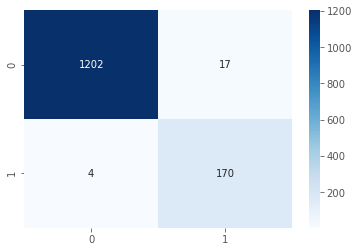

In [28]:
sns.heatmap(nb_conf, annot=True, cmap='Blues', fmt='g')
plt.show()


### Logistic Regression

In [29]:
params = {'C': [1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10], 
          'fit_intercept':[True, False]}
grid = GridSearchCV(LogisticRegression(), param_grid=params, n_jobs=-1, verbose=0)
grid.fit(x_train, y_train)
grid.best_params_

/home/vlado/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'C': 100.0, 'fit_intercept': True}

In [30]:
lr = LogisticRegression(C=1000000000.0, fit_intercept=True)
lr.fit(x_train, y_train)

LogisticRegression(C=1000000000.0)

In [31]:
print(f'Training Score: {lr.score(x_train, y_train)}')
print(f'Testing Score: {lr.score(x_test, y_test)}')
print(f'Recall: {recall_score(lr.predict(x_test), y_test)}')
print(f'Precision: {precision_score(lr.predict(x_test), y_test)}')
print(f'F1: {f1_score(lr.predict(x_test), y_test)}')



Training Score: 0.9992821249102656
Testing Score: 0.9597989949748744
Recall: 0.7937219730941704
Precision: 0.946524064171123
F1: 0.8634146341463413


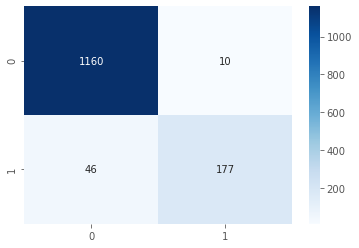

In [32]:
lr_conf = confusion_matrix(lr.predict(x_test), y_test)
sns.heatmap(lr_conf, annot=True, cmap='Blues', fmt='g')
plt.show()

### Random Forest

In [33]:
# params = {'n_estimators': [100, 500, 1000, 2000, 5000, 10000], 'max_depth':[10, 20, 50, 100, 150]}
# grid = GridSearchCV(RandomForestClassifier(), param_grid=params, n_jobs=-1, verbose=0)
# grid.fit(x_train, y_train)
# grid.best_params_

In [34]:
rf = RandomForestClassifier(n_estimators = 100, max_depth =150)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=150)

In [35]:
print(f'Training Score: {rf.score(x_train, y_train)}')
print(f'Testing Score: {rf.score(x_test, y_test)}')
print(f'Recall: {recall_score(rf.predict(x_test), y_test)}')
print(f'Precision: {precision_score(rf.predict(x_test), y_test)}')
print(f'F1: {f1_score(rf.predict(x_test), y_test)}')



Training Score: 0.9992821249102656
Testing Score: 0.9798994974874372
Recall: 1.0
Precision: 0.8502673796791443
F1: 0.9190751445086706


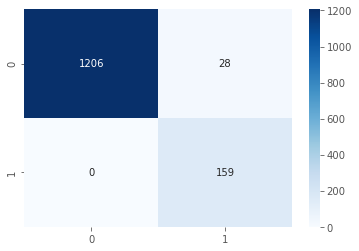

In [36]:
rf_conf = confusion_matrix(rf.predict(x_test), y_test)
sns.heatmap(rf_conf, fmt='g', annot=True, cmap='Blues')
plt.show()

### Gaussian SVM

In [37]:
# params = {'C': [1e-2, 1e-1, 1, 1e3, 1e5, 1e7, 1e9], 'gamma':[0.001, 0.01, 0.1, 1, 2, 10, 50]}
# grid = GridSearchCV(SVC(), param_grid=params, n_jobs=-1, verbose=0)
# grid.fit(x_train, y_train)
# grid.best_params_

In [38]:
gaussian_svm = SVC(C=1000 , gamma= 0.001)
gaussian_svm.fit(x_train, y_train)

SVC(C=1000, gamma=0.001)

In [39]:
print(f'Training Score: {gaussian_svm.score(x_train, y_train)}')
print(f'Testing Score: {gaussian_svm.score(x_test, y_test)}')
print(f'Recall: {recall_score(gaussian_svm.predict(x_test), y_test)}')
print(f'Precision: {precision_score(gaussian_svm.predict(x_test), y_test)}')
print(f'F1: {f1_score(gaussian_svm.predict(x_test), y_test)}')


Training Score: 0.9966499162479062
Testing Score: 0.9863603732950467
Recall: 0.9941176470588236
Precision: 0.9037433155080213
F1: 0.9467787114845937


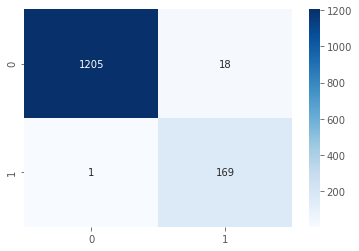

In [40]:
gaussian_conf = confusion_matrix(gaussian_svm.predict(x_test), y_test)
sns.heatmap(gaussian_conf, fmt='g', annot=True, cmap='Blues')
plt.show()

### AdaBoost

In [41]:
# params = {'n_estimators': [20, 50, 100, 500, 1000], 'learning_rate': [0.001, 0.01, 0.1, 1, 5]}
# grid = GridSearchCV(AdaBoostClassifier(base_estimator=LogisticRegression()), param_grid=params)
# grid.fit(x_train, y_train)
# grid.best_params_

In [42]:
ada = AdaBoostClassifier(base_estimator=LogisticRegression(), learning_rate=1, n_estimators=1000)
ada.fit(x_train, y_train)

AdaBoostClassifier(base_estimator=LogisticRegression(), learning_rate=1,
                   n_estimators=1000)

In [43]:
print(f'Training Score: {ada.score(x_train, y_train)}')
print(f'Testing Score: {ada.score(x_test, y_test)}')
print(f'Recall: {recall_score(ada.predict(x_test), y_test)}')
print(f'Precision: {precision_score(ada.predict(x_test), y_test)}')
print(f'F1: {f1_score(ada.predict(x_test), y_test)}')


Training Score: 0.9703278296243121
Testing Score: 0.955491744436468
Recall: 0.9921259842519685
Precision: 0.6737967914438503
F1: 0.802547770700637


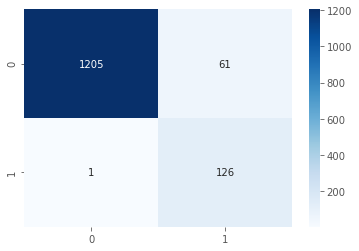

In [44]:
ada_conf = confusion_matrix(ada.predict(x_test), y_test)
sns.heatmap(ada_conf, fmt='g', annot=True, cmap='Blues')
plt.show()

## Models Assessment

We achieved fairly different results with different models. We started with simpler models - we tried a probabilistic model like Naive Bayes that uses Bayes Theorem and statistics to predict, then we moved on with the Logistic Regression as the first model with Gradient descent, very simple one, we tried to project the data in higher dimensional space with Gaussian SVM. Then we moved on a boosting process with Random Forest which is an ensemble of Trees(or if-else condition based model). Then we tried to boost Logistic regression with AdaBoost in order to difer from RandomForest(by default Ada uses Trees as well).

We observed the best results in terms of recall for class 1 with Random Forest. It  never confused a non spam message with a spam on testing data! This means we will rarely have a Spam Message in our main sections. But we lose a fair amount of real message, wrongly classified as spams.Logistic Regression is the top performer in terms of keeping the real messages but it let many spams in as well.Adaboost with Logistic Regressions has similar behavior to the other ensemble algorithm - Random Forest - but its worse.  

So as we said in the beginning the main metric we'll use to evaluate and make a final call is Accuracy because it gives a nice balance for the tradeoff we observe with this problem.

And the highest accuracy + highest mean of all the other 3 metrics we use is achieved by the Guassian SVM. MultiNomial Naive Bayes is close but it's a little bit worse. Also because of the size of the dataset which is not very large this is relatively fast, light and simple model so we can only be happy with that.

Let's now save and export our model so we can use it later in different environments and with different data. I'll comment the code so we don't rewrite the pickled file every time we run the notebook.

In [45]:
# import pickle
# from sklearn.pipeline import  Pipeline
# from sklearn.preprocessing import FunctionTransformer


In [46]:
# clean_transformer = FunctionTransformer(custom_clean_transformer)
# stem_transformer = FunctionTransformer(custom_stem_transformer)

In [47]:
# gaussian_svm_pipeline = Pipeline([('vectorizer', tf_idf), ('classifier', gaussian_svm)])

In [48]:
# gaussian_svm_pipeline.fit(data['text'], data['target'])

In [49]:
# save_classifier = open("spam_detector.pickle","wb")
# pickle.dump(gaussian_svm_pipeline, save_classifier)
# save_classifier.close()

The model is now ready to be used in any environment and with any data in text format.

## Resources:

- https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html